## RROC scattering rate

**Resonance Raman optical cycling for high-fidelity fluorescence detection of molecules**   
J. C. Shaw, J. C. Schnaubelt, and D. J. McCarron  
Phys. Rev. Research 3, L042041.  
DOI: https://doi.org/10.1103/PhysRevResearch.3.L042041

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp_local as pylcp

In [22]:
Gamma = 6.6 # MHz

H0_X_v0, mu_p_X_v0, U_X_v0, basis_X_v0 = pylcp.hamiltonians.XFmolecules.Xstate(
    N = 1, I = 1/2, 
    gamma = 74.7950/Gamma, # spin-rotation coupling for v=0 N=1
    b = 97.0827/Gamma, c = 30.2675/Gamma, CI = 0.0023/Gamma, q0 = 0, q2 = 0, # hyperfine parameters for v=0 N=1
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, 
    muN = cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    return_basis = True
    )
E_X_v0 = np.unique(np.diag(H0_X_v0))

H0_A_v0, mu_p_A_v0, basis_A_v0 = pylcp.hamiltonians.XFmolecules.Astate(
    J = 1/2, I = 1/2, P = +1, 
    a = 0, b = 0, c = 0, # related to hyperfine structure
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, 
    muN = cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    # glprime = -0.26395, greprime=4.37e-4, # extra contribution from electron to g-factor
    return_basis = True
    )
E_A_v0 = np.unique(np.diag(H0_A_v0))

dijp_X_v0_A_v0 = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    basis_X_v0, basis_A_v0, I = 1/2, S = 1/2, UX = U_X_v0
    )

# hamiltonian = pylcp.hamiltonian(H0_X_v0, H0_A_v0, mu_p_X_v0, mu_p_A_v0, dijp_X_v0_A_v0)
hamiltonian = pylcp.hamiltonian()
hamiltonian.add_H_0_block('X_v0', H0_X_v0) # H0 includes the energy of the states
hamiltonian.add_H_0_block('A_v0', H0_A_v0)
hamiltonian.add_mu_q_block('X_v0', mu_p_X_v0) # mu_p includes the magnetic dipole moment of the states, so muB is not needed as an input. 'p' and 'q' labelling are mixed, which is confusing. 'p' is for lab frame indices, and 'q' is for molecule frame indices. It think it should all be 'p' here.
hamiltonian.add_mu_q_block('A_v0', mu_p_A_v0)
hamiltonian.add_d_q_block('X_v0', 'A_v0', dijp_X_v0_A_v0, k=1, gamma=1) # dijp only includes the contributions from angular momenta, not transition dipole moments, so Gamma is needed as an input, for Gamma's that's not 1. Again, the 'p' and 'q' labelling is mixed.


In [23]:
hamiltonian.return_full_H({'X_v0->A_v0': [1, 0, 0]}, [0, 0, 0])

array([[-1.63257007e+01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  1.36882485e-15+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -1.63257007e+01+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  1.36882485e-15+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  2.47626696e-01+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j, -1.63257007e+01+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         1.36882485e-15+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.000000

In [8]:
omega_X_v0_A_v0 = 2 * np.pi * (cts.c/663e-9) # Hz
Isat_X_v0_A_v0 = cts.hbar * omega_X_v0_A_v0**3 * (2*np.pi*Gamma*1e6) / (12*np.pi*cts.c**2) # in W/m^2, 2*np.pi*Gamma*1e6 is the actually Gammam value = 2pi*6.6e6 Hz
# print("I_sat =", Isat*1e-4*1e3, "mW/cm^2.")

magField = pylcp.constantMagneticField([0, 0, 5]) # gauss

# A litle helper function to make the MOT:
def six_beam_CaF_MOT(s, det):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X_v0):
        if ii<3:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A_v0[-1] - Eg_i)+det, pol=+1,
                beam_type=pylcp.infinitePlaneWaveBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A_v0[-1] - Eg_i)+det, pol=-1,
                beam_type=pylcp.infinitePlaneWaveBeam
                )

    return laserBeams

Completed in 21.73 s.                                               


array([0.        , 0.09482716, 0.16674976, ..., 0.13517401, 0.12372098,
       0.12998269])

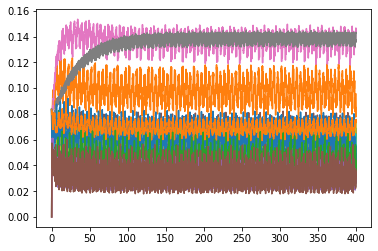

In [9]:
# The detunings used in the PRAs:
dets = 0
P = 0.1 # W
intensities = 2.*P/(np.pi*0.012**2)/Isat_X_v0_A_v0

laserBeams = {}
laserBeams['X_v0->A_v0'] = six_beam_CaF_MOT(intensities, dets)

scatter_rate_observable = np.diagflat([0] * H0_X_v0.shape[0] + [1] * H0_A_v0.shape[0]) # an observable whose expectation value is the total excited state population (i.e. a diagonal matrix with 1's only on the excited state diagonal)

obe = pylcp.obe(laserBeams, magField, hamiltonian, include_mag_forces=True)
init_population = np.array([1] * H0_X_v0.shape[0] + [0] * H0_A_v0.shape[0])
init_population = init_population / init_population.sum()  # Normalize the populations

obe.set_initial_rho_from_populations(init_population)
obe.evolve_density([0, 400], t_eval=np.linspace(0, 400, 4000), progress_bar=True)
population = np.array([[np.abs(obe.sol.rho[i, i, j]) for i in range(obe.sol.rho.shape[0])] for j in range(obe.sol.rho.shape[-1])])
plt.plot(obe.sol.t, population)

obe.observable(scatter_rate_observable)